# HELOC Credit Approval 
This notebook is ispired by the [AIX360](https://aix360.mybluemix.net/) [Credit Approval Tutorial](https://github.com/gianluigilopardo/AIX360/blob/master/examples/tutorials/HELOC.ipynb), showing different explainability methods.
Two interpretable models (XGBoost and RuleFit) are shown here, to be compared with the *Data Scientist explanations* methods provided in the above notebook.

The dataset is from the [FICO Explainable Machine Learning Challenge](https://community.fico.com/s/explainable-machine-learning-challenge) and it is about credit approval.

In [1]:
# math
import numpy as np
import pandas as pd
pd.options.display.max_columns = None

# models
from sklearn.model_selection import train_test_split
from rulefit import RuleFit
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# metrics
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# visual
import matplotlib.pyplot as plt
from xgboost import plot_tree
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

# utils
import random
SEED = 42
random.seed(SEED)
import warnings
warnings.filterwarnings('ignore')

In [2]:
path = 'heloc_dataset_v1.csv'
df = pd.read_csv(path) 
df.head()

,RiskPerformance,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,MaxDelq2PublicRecLast12M,MaxDelqEver,NumTotalTrades,NumTradesOpeninLast12M,PercentInstallTrades,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance
0,Bad,55,144,4,84,20,3,0,83,2,3,5,23,1,43,0,0,0,33,-8,8,1,1,69
1,Bad,61,58,15,41,2,4,4,100,-7,0,8,7,0,67,0,0,0,0,-8,0,-8,-8,0
2,Bad,67,66,5,24,9,0,0,100,-7,7,8,9,4,44,0,4,4,53,66,4,2,1,86
3,Bad,66,169,1,73,28,1,1,93,76,6,6,30,3,57,0,5,4,72,83,6,4,3,91
4,Bad,81,333,27,132,12,0,0,100,-7,7,8,12,0,25,0,1,1,51,89,3,1,0,80


In [3]:
df.describe()

,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,MaxDelq2PublicRecLast12M,MaxDelqEver,NumTotalTrades,NumTradesOpeninLast12M,PercentInstallTrades,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance
count,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000
mean,67.425758,184.205373,8.543455,73.843293,19.428052,0.042738,-0.142843,86.661536,6.762406,4.928291,5.510183,20.856965,1.253083,32.166460,-0.325366,0.868152,0.812602,31.629888,39.158906,3.185008,0.976097,0.018071,62.079166
std,21.121621,109.683816,13.301745,38.782803,13.004327,2.513910,2.367397,25.999584,20.501250,3.756275,3.971182,14.580905,3.068684,20.128634,6.067556,3.179304,3.143698,30.060140,42.101601,4.413173,4.060995,3.358135,27.711565
min,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000
25%,63.000000,118.000000,3.000000,52.000000,12.000000,0.000000,0.000000,87.000000,-7.000000,4.000000,5.000000,12.000000,0.000000,20.000000,-7.000000,0.000000,0.000000,5.000000,-8.000000,2.000000,1.000000,0.000000,47.000000
50%,71.000000,178.000000,5.000000,74.000000,19.000000,0.000000,0.000000,96.000000,-7.000000,6.000000,6.000000,20.000000,1.000000,31.000000,0.000000,1.000000,1.000000,25.000000,47.000000,3.000000,2.000000,0.000000,67.000000
75%,79.000000,249.500000,11.000000,95.000000,27.000000,1.000000,0.000000,100.000000,14.000000,7.000000,8.000000,29.000000,3.000000,44.000000,1.000000,2.000000,2.000000,54.000000,79.000000,5.000000,3.000000,1.000000,82.000000
max,94.000000,803.000000,383.000000,383.000000,79.000000,19.000000,19.000000,100.000000,83.000000,9.000000,8.000000,104.000000,19.000000,100.000000,24.000000,66.000000,66.000000,232.000000,471.000000,32.000000,23.000000,18.000000,100.000000


In [4]:
# utils function

def riskMapper(x):
    if x == 'Bad':
        x = 1
    else:
        x = 0
    return x

def renameDic(dic):
    dicNew = {}
    for k in dic:
        f = int(k.replace("f",""))
        dicNew[features[f]] = dic[k]
    return dicNew

In [5]:
df.size

251016

In [6]:
df.RiskPerformance = df.RiskPerformance.map(lambda x: riskMapper(x))
df.head()

,RiskPerformance,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,MaxDelq2PublicRecLast12M,MaxDelqEver,NumTotalTrades,NumTradesOpeninLast12M,PercentInstallTrades,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance
0,1,55,144,4,84,20,3,0,83,2,3,5,23,1,43,0,0,0,33,-8,8,1,1,69
1,1,61,58,15,41,2,4,4,100,-7,0,8,7,0,67,0,0,0,0,-8,0,-8,-8,0
2,1,67,66,5,24,9,0,0,100,-7,7,8,9,4,44,0,4,4,53,66,4,2,1,86
3,1,66,169,1,73,28,1,1,93,76,6,6,30,3,57,0,5,4,72,83,6,4,3,91
4,1,81,333,27,132,12,0,0,100,-7,7,8,12,0,25,0,1,1,51,89,3,1,0,80


In [7]:
X = df.drop(columns = 'RiskPerformance')
features = X.columns
X = X.values
y = df['RiskPerformance'].values
data_dmatrix = xgb.DMatrix(data=X,label=y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=SEED, stratify = y)

## XGBoost
The idea of boosting approach in machine learning is to create highly accurate predictions by combining many low-accurate rules. ”Wisdom of the crowds” is the basis concept behind Boosting, which takes a large amount of its foundations in the game theory field.

Boosting assumes the availability of a base or weak classifier, which it will see as a ”black-box” and that can be called repeatedly. This classification algorithm has to be at least better than taking random predictions (weak learning assumption). A boosting algorithm learns by repeatedly calling the base learning algorithm, but if this always works with the same data and in the same way, we can’t expect anything interesting. The key idea is to choose training sets for the base classifier in such a way to infer something new each time it is called.

[XGBoost](https://xgboost.ai/) stands for ”eXtreme Gradient Boosting”. It is a scalable, fast and well-performing tree boosting system, widely used in the data science community. It is designed for optimizing computational resources as it performs different optimization improvements which make it better than other boosting technique.

In [8]:
# Do cross validation to better choose (some) parameters
# or if you trust me set it False
CV = False

if CV:
    learning_rate =  [0.001, 0.01, 0.1]
    max_depth = np.arange(3,6)
    alpha = [0,2,10]
    colsample_bytree = [0,0.2,0.5]
    parameters = {'learning_rate': learning_rate, 'max_depth': max_depth,
                 'alpha': alpha, 'colsample_bytree':colsample_bytree}
    xgb_mod = xgb.XGBClassifier(objective='reg:logistic')
    xgb_mod = GridSearchCV(xgb_mod, parameters, scoring='f1', cv=5)
    xgb_mod.fit(X_train,y_train)
    print("The best parameters for XGB Classifier are %s with a score of %0.2f" % (xgb_mod.best_params_, xgb_mod.best_score_))
    
else: 
    xgb_mod = xgb.XGBClassifier(objective='reg:logistic', colsample_bytree=0.2, alpha=10,
                            learning_rate=0.1, max_depth=4, n_estimators=100)
    xgb_mod.fit(X_train,y_train)

In [9]:
xgb_pred = xgb_mod.predict(X_test)
print('Training accuracy:', accuracy_score(y_train, xgb_mod.predict(X_train)))
print('Test accuracy:', accuracy_score(y_test, xgb_pred))

Training accuracy: 0.7444338205163229
Test accuracy: 0.7281708094327597


By looking at *Test accuracy* we se that XGBoost classifier outperformes Boolean Rule and Logistic Rule Regression models in the HELOC example.

What is more, it also provides a scoring system for undestand features importance.

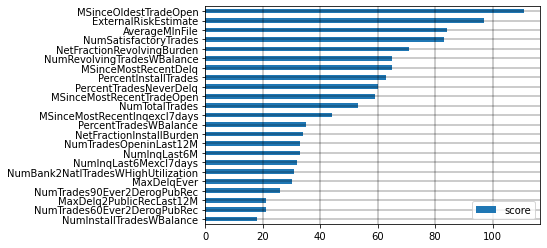

In [10]:
if CV:
    xgb_mod = xgb_mod.best_estimator_
features_scoring = xgb_mod.get_booster().get_score(importance_type='weight')
features_scoring = renameDic(features_scoring)
features = list(features_scoring.keys())
scores = list(features_scoring.values())

data = pd.DataFrame(data=scores, index=features, columns=["score"]).sort_values(by = "score", ascending=True)
data.plot(kind='barh')
plt.grid(color='k', linewidth=0.4)
plt.show()

In [11]:
data.sort_values(by='score', ascending=False).head()

,score
MSinceOldestTradeOpen,111
ExternalRiskEstimate,97
AverageMInFile,84
NumSatisfactoryTrades,83
NetFractionRevolvingBurden,71


We could also go deeper: individual trees are small and can be easily shown and understood, but they are many.

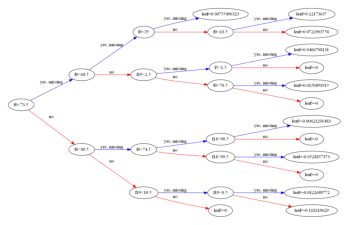

In [12]:
plot_tree(xgb_mod, num_trees=1, rankdir='LR')
plt.show()

## RuleFit
[RuleFit](https://arxiv.org/pdf/0811.1679.pdf) is an interesting method combining decision trees and linear regreesion to account for interactions between features.

In [13]:
rf = RuleFit()
rf.fit(X_train, y_train, feature_names=features)
rf_pred = rf.predict(X_test)

We can look at the rules learn from the trees which result to be most important to the regression.

In [14]:
rules = rf.get_rules()
rules = rules[rules.coef != 0].sort_values("importance", ascending=False)
rules = pd.DataFrame(rules)
pd.set_option('display.max_colwidth', None)
rules.head(10)

,rule,type,coef,support,importance
736,NumInqLast6Mexcl7days > 42.5 & AverageMInFile > 70.5 & NumRevolvingTradesWBalance <= 54.5,rule,-0.047784,0.486134,0.023883
1516,PercentTradesWBalance <= 5.5 & MaxDelqEver <= 53.5 & NumBank2NatlTradesWHighUtilization <= 73.5,rule,-0.054003,0.737357,0.023765
702,NumSatisfactoryTrades > -7.5 & NetFractionRevolvingBurden <= 96.5,rule,0.042103,0.440457,0.020902
426,NumTradesOpeninLast12M > 5.5 & NumInqLast6Mexcl7days > 50.5 & NumBank2NatlTradesWHighUtilization <= 87.5,rule,-0.040609,0.549755,0.020204
587,NumInstallTradesWBalance <= 5.5 & MaxDelqEver <= 43.5,rule,-0.037739,0.507341,0.018868
1570,MSinceMostRecentInqexcl7days <= 46.0 & AverageMInFile <= 78.5 & NumSatisfactoryTrades > -7.5 & NumSatisfactoryTrades <= 0.5,rule,0.033683,0.417618,0.016612
888,AverageMInFile > 63.5 & NumSatisfactoryTrades > 0.5 & PercentTradesNeverDelq <= 57.5 & NumTrades90Ever2DerogPubRec <= 436.0,rule,-0.038764,0.215334,0.015934
986,NumBank2NatlTradesWHighUtilization <= 43.5 & NetFractionRevolvingBurden > 87.5,rule,-0.030758,0.520392,0.015366
763,PercentTradesWBalance <= 7.5 & NumBank2NatlTradesWHighUtilization <= 58.5,rule,-0.033498,0.717781,0.015077
1628,NumTrades90Ever2DerogPubRec <= 268.5 & AverageMInFile <= 67.5 & AverageMInFile > 54.5,rule,0.033471,0.252855,0.014548
